In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###Набор данных «Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.», в котором находятся данные о CO2 с марта 1958 года по декабрь 2001 года.

In [2]:
data = sm.datasets.co2.load_pandas()
y = data.data

In [3]:
y.head(10)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
1958-05-03,316.9
1958-05-10,NaN
1958-05-17,317.5
1958-05-24,317.9
1958-05-31,NaN


### Преобработка данных

In [9]:
y = y['co2'].resample('MS').mean()
y = y.fillna(y.bfill())

In [10]:
y.head(10)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
1958-08-01    314.950000
1958-09-01    313.500000
1958-10-01    313.425000
1958-11-01    313.425000
1958-12-01    314.700000
Freq: MS, Name: co2, dtype: float64

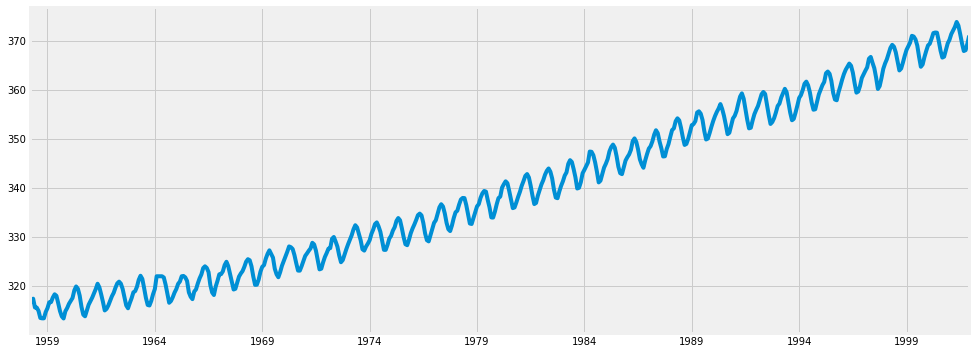

In [12]:
y.plot(figsize=(15, 6))

In [ ]:
#Модель ARIMA (AutoregRessive Integrated Moving Average) – один из наиболее распространённых методов анализа и прогнозирования временных рядов. Эта модель позволяет обработать данные временного ряда, чтобы лучше понять этот ряд или предсказать его развитие.

#ARIMA использует три основных параметра (p, d, q), которые выражаются целыми числами. Потому модель также записывается как ARIMA(p, d, q). Вместе эти три параметра учитывают сезонность, тенденцию и шум в наборах данных:

#p – порядок авторегрессии (AR), который позволяет добавить предыдущие значения временного ряда. Этот параметр можно проиллюстрировать утверждением «завтра, вероятно, будет тепло, если в последние три дня было тепло».
#d – порядок интегрирования (I; т. е. порядок разностей исходного временного ряда). Он добавляет в модель понятия разности временных рядов (определяет количество прошлых временных точек, которые нужно вычесть из текущего значения). Этот параметр иллюстрирует такое утверждение: «завтра, вероятно, будет такая же температура, если разница в температуре за последние три дня была очень мала».
#q – порядок скользящего среднего (MA), который позволяет установить погрешность модели как линейную комбинацию наблюдавшихся ранее значений ошибок.
#Для отслеживания сезонности используется сезонная модель ARIMA – ARIMA(p,d,q)(P,D,Q)s. Здесь (p, d, q) – несезонные параметры, описанные выше, а (P, D, Q) следуют тем же определениям, но применяются к сезонной составляющей временного ряда. Параметр s определяет периодичность временного ряда (4 – квартальные периоды, 12 – годовые периоды и т.д.).

#Сезонная модель ARIMA может показаться сложной из-за многочисленных параметров. В следующем разделе вы узнаете, как автоматизировать процесс определения оптимального набора параметров для сезонной модели временных рядов ARIMA.

###Подбор параметров для модели ARIMA

In [13]:
#Сетчатый поиск
#Определим p, d и q в диапазоне 0-2
p = d = q = range(0, 2)

In [14]:
#Сгенерируем различные комбинации p, q и q
pdq = list(itertools.product(p, d, q))

In [15]:
#Сгенерируем комбинации сезонных параметров p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [16]:
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
#AIC (Akaike Information Criterion) оценивает, насколько хорошо модель соответствует данным, принимая во внимание общую сложность модели. 
#Чем меньше функций использует модель, чтобы достичь соответствия данным, тем выше её показатель AIC. Поэтому нужно найти модель с наименьшим значением AIC.

In [17]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.3436240338315
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.828234141261
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727640981
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320035
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878518713133
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578977746117
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912957195
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048754156435
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327461802
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941066935976
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716916696
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1079.499039374615
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:930.5388008098283
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893608688
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912989044791
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.8086923024293
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194076

In [ ]:
#Согласно полученному выводу, SARIMAX(1, 1, 1)x(1, 1, 1, 12) получает наименьший показатель AIC (277.78). 
#Следовательно, эти параметры можно считать оптимальными.

###Определение модели временных рядов ARIMA

In [18]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.162      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.811      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


In [19]:
#p имеет близкое к 0,05 значение, поэтому разумно сохранить в модели все параметры.

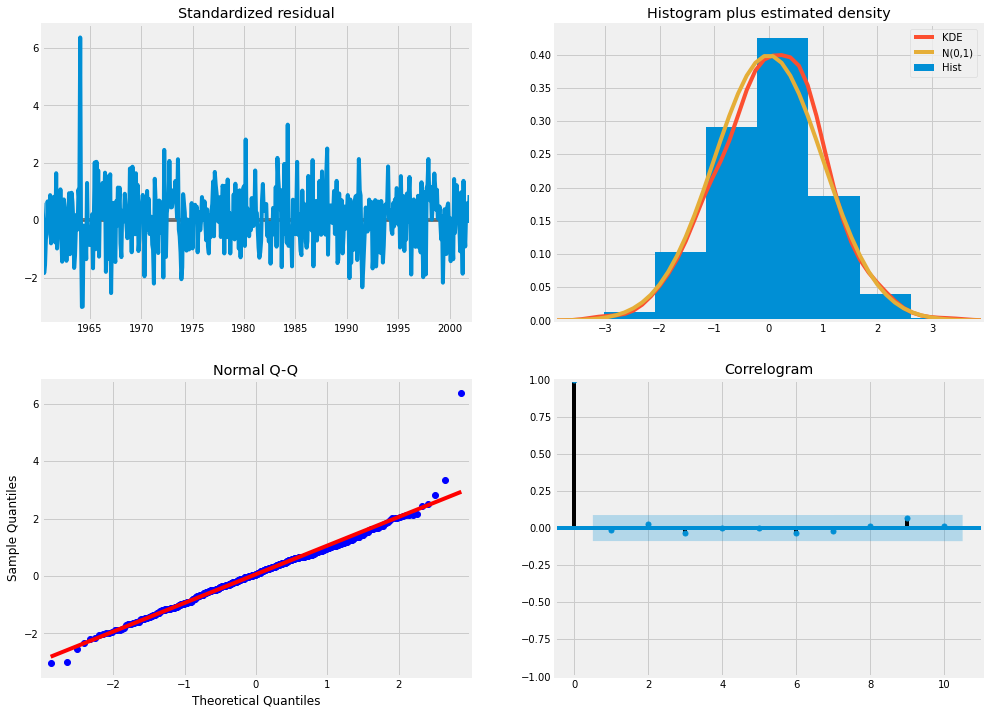

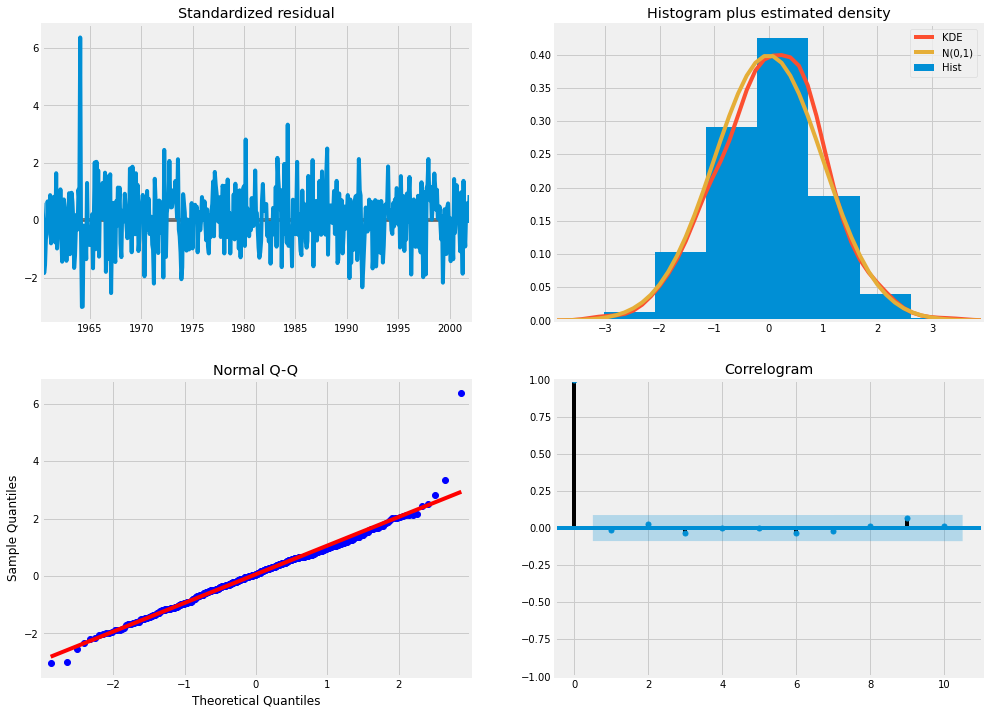

In [20]:
results.plot_diagnostics(figsize=(15, 12))

In [ ]:
#Главная задача – убедиться, что остатки модели некоррелированные и распределяются с нулевым средним значением. 
#Если сезонная модель ARIMA не удовлетворяет этим свойствам, это значит, что ее еще можно улучшить.

In [ ]:
#1).На верхнем правом графике красная линия KDE находится близко к линии N (0,1) (где N (0,1) является стандартным обозначением нормального распределения со средним 0 и стандартным отклонением 1) . 
#Это хороший признак того, что остатки нормально распределены.

#2).График q-q в левом нижнем углу показывает, что упорядоченное распределение остатков (синие точки) следует линейному тренду выборок, взятых из стандартного распределения N (0, 1). 
#Опять же, это признак того, что остатки нормально распределены.

#3).Остатки с течением времени (верхний левый график) не показывают явной сезонности и кажутся белыми шумами. 
#Это подтверждается графиком автокорреляции (внизу справа), который показывает, что остатки временных рядов имеют низкую корреляцию с запаздывающими данными.

###Прогнозирование временных рядов

In [ ]:
#Аргумент dynamic=False включает пошаговое прогнозирование, а это означает, что прогнозы в каждой точке генерируются с использованием полной истории вплоть до этой точки.

In [21]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

In [23]:
pred_ci.head(10)

,lower co2,upper co2
1998-01-01,364.453368,365.675242
1998-02-01,365.373504,366.595378
1998-03-01,366.404745,367.626619
1998-04-01,367.908503,369.130376
1998-05-01,368.389525,369.611397
1998-06-01,367.802556,369.024428
1998-07-01,366.481986,367.703859
1998-08-01,364.754336,365.976209
1998-09-01,363.200087,364.421959
1998-10-01,363.378481,364.600354


In [24]:
pred.predicted_mean.head(10)

1998-01-01    365.064305
1998-02-01    365.984441
1998-03-01    367.015682
1998-04-01    368.519439
1998-05-01    369.000461
1998-06-01    368.413492
1998-07-01    367.092923
1998-08-01    365.365272
1998-09-01    363.811023
1998-10-01    363.989417
Freq: MS, dtype: float64

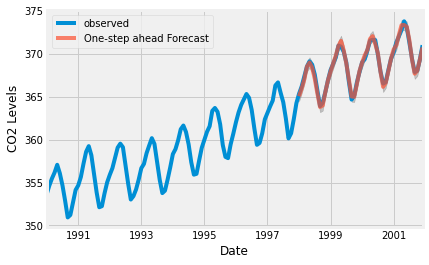

In [22]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

###Точность прогноза - MSE (Mean Squared Error)

In [25]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':] # Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


###Динамический прогноз 

In [ ]:
#В этом случае нужно использовать только информацию из временных рядов до определенной точки; затем прогнозы сгенерируются с помощью значений из предыдущих прогнозируемых временных точек.

In [26]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

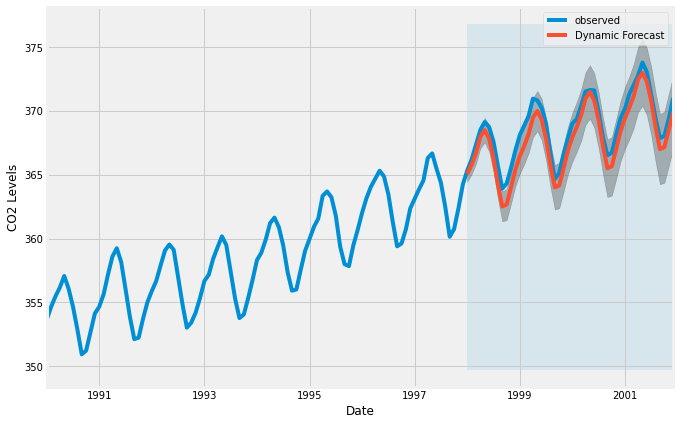

In [29]:
ax = y['1990':].plot(label='observed', figsize=(10, 7))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
pred_dynamic_ci.iloc[:, 0],
pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

In [30]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


###Создание и визуализация прогноза

In [31]:
# Получить прогноз на 500 шагов вперёд
pred_uc = results.get_forecast(steps=500)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int()

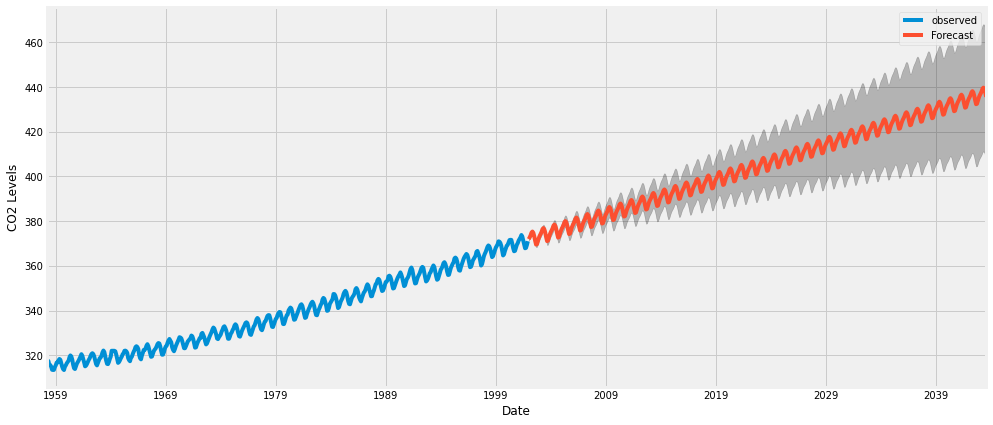

In [33]:
ax = y.plot(label='observed', figsize=(15, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()